### **1. Import Libraries and Retrieve Data**

In [61]:
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import kruskal
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

In [62]:
data_original = yf.download('USDINR=X', start='2020-01-01', end='2024-10-21', progress=False)

In [63]:
data_original.columns

MultiIndex([( 'Close', 'USDINR=X'),
            (  'High', 'USDINR=X'),
            (   'Low', 'USDINR=X'),
            (  'Open', 'USDINR=X'),
            ('Volume', 'USDINR=X')],
           names=['Price', 'Ticker'])

In [64]:
#Flatten MultiIndex Columns to simplify 
if isinstance(data_original.columns, pd.MultiIndex):
    data_original.columns = ['_'.join(col).strip() for col in data_original.columns.values]

#Remove the ticker part(e.g. USDTRY=X from column name)
data_original.columns = [col.split('_')[0] for col in data_original.columns]

data = data_original.copy()
data = data.reset_index()
data

,Date,Close,High,Low,Open,Volume
0,2020-01-01,71.275803,71.430000,71.029999,71.275803,0
1,2020-01-02,71.025002,71.405502,71.025002,71.025002,0
2,2020-01-03,71.415001,71.995003,71.229797,71.415001,0
3,2020-01-06,71.731003,72.190002,71.703003,71.720001,0
4,2020-01-07,71.787003,72.032600,71.668999,72.019997,0
...,...,...,...,...,...,...
1248,2024-10-14,84.168297,84.168404,83.976700,84.168297,0
1249,2024-10-15,84.048500,84.072800,84.018097,84.048500,0
1250,2024-10-16,84.056198,84.094299,83.989998,84.056198,0
1251,2024-10-17,84.039299,84.087898,84.002998,84.039299,0


#### **1.1 Initial Analysis**

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1253 non-null   datetime64[ns]
 1   Close   1253 non-null   float64       
 2   High    1253 non-null   float64       
 3   Low     1253 non-null   float64       
 4   Open    1253 non-null   float64       
 5   Volume  1253 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 58.9 KB


In [66]:
#Check for NULL values
data.isnull().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [67]:
data.describe()

,Date,Close,High,Low,Open,Volume
count,1253,1253.000000,1253.000000,1253.000000,1253.000000,1253.0
mean,2022-05-26 09:34:37.254588928,78.346095,78.557637,78.148084,78.351184,0.0
min,2020-01-01 00:00:00,70.718002,70.952499,70.606499,70.718903,0.0
25%,2021-03-15 00:00:00,74.405998,74.586998,74.180199,74.420303,0.0
50%,2022-05-26 00:00:00,77.584099,77.829498,77.436501,77.598999,0.0
75%,2023-08-08 00:00:00,82.825699,82.984299,82.657097,82.825699,0.0
max,2024-10-18 00:00:00,85.194000,85.185997,84.018303,85.194000,0.0
std,NaN,4.247338,4.201870,4.292841,4.241094,0.0


#### **2. Data Preprocessing**

In [68]:
data = data.drop(columns=['Volume'])

In [69]:
def create_date_features(df, date_column):
    # --- Day-Level Features ---
    df['day_of_month'] = df[date_column].dt.day
    df['day_of_year'] = df[date_column].dt.dayofyear
    df['day_of_week'] = df[date_column].dt.dayofweek
    df['is_weekend'] = df[date_column].dt.dayofweek > 4
    df['is_business_day'] = df[date_column].dt.weekday < 5

    # --- Week-Level Featuers ---
    df['week_of_year'] = df[date_column].dt.isocalendar().week
    df['week_of_month'] = df[date_column].apply(lambda d: (d.day - 1) // 7 + 1)  # Week of the month

    # --- Month-Level Features ---
    df['month'] = df[date_column].dt.month
    df['is_month_start'] = df[date_column].dt.is_month_start.astype(int)
    df['is_month_end'] = df[date_column].dt.is_month_end.astype(int)
    df['days_in_month'] = df[date_column].dt.days_in_month
    df['half_of_month'] = np.where(df[date_column].dt.day <= 15, 1, 2)
    df['days_until_month_end'] = df[date_column].dt.days_in_month - df[date_column].dt.day

    # --- Quarter-Level Features ---
    df['quarter'] = df[date_column].dt.quarter
    df['is_quarter_start'] = df[date_column].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df[date_column].dt.is_quarter_end.astype(int)

    # --- Year-Level Features ---
    df['year'] = df[date_column].dt.year
    df['is_year_start'] = df[date_column].dt.is_year_start.astype(int)
    df['is_year_end'] = df[date_column].dt.is_year_end.astype(int)
    df['days_until_year_end'] = 365 - df[date_column].dt.dayofyear

    # --- Seasonal Features ---
    # 0: Winter, 1: Spring, 2: Summer, 3: Fall
    df["season"] = np.where(df.month.isin([12, 1, 2]), 0, 1)
    df["season"] = np.where(df.month.isin([6, 7, 8]), 2, df["season"])
    df["season"] = pd.Series(np.where(df.month.isin([9, 10, 11]), 3, df["season"])).astype("int8")

    return df

In [70]:
create_date_features(data, 'Date')

,Date,Close,High,Low,Open,day_of_month,day_of_year,day_of_week,is_weekend,is_business_day,...,half_of_month,days_until_month_end,quarter,is_quarter_start,is_quarter_end,year,is_year_start,is_year_end,days_until_year_end,season
0,2020-01-01,71.275803,71.430000,71.029999,71.275803,1,1,2,False,True,...,1,30,1,1,0,2020,1,0,364,0
1,2020-01-02,71.025002,71.405502,71.025002,71.025002,2,2,3,False,True,...,1,29,1,0,0,2020,0,0,363,0
2,2020-01-03,71.415001,71.995003,71.229797,71.415001,3,3,4,False,True,...,1,28,1,0,0,2020,0,0,362,0
3,2020-01-06,71.731003,72.190002,71.703003,71.720001,6,6,0,False,True,...,1,25,1,0,0,2020,0,0,359,0
4,2020-01-07,71.787003,72.032600,71.668999,72.019997,7,7,1,False,True,...,1,24,1,0,0,2020,0,0,358,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,2024-10-14,84.168297,84.168404,83.976700,84.168297,14,288,0,False,True,...,1,17,4,0,0,2024,0,0,77,3
1249,2024-10-15,84.048500,84.072800,84.018097,84.048500,15,289,1,False,True,...,1,16,4,0,0,2024,0,0,76,3
1250,2024-10-16,84.056198,84.094299,83.989998,84.056198,16,290,2,False,True,...,2,15,4,0,0,2024,0,0,75,3
1251,2024-10-17,84.039299,84.087898,84.002998,84.039299,17,291,3,False,True,...,2,14,4,0,0,2024,0,0,74,3


In [71]:
# Simple Moving Averages
data['SMA_5'] = data['Close'].rolling(window=5).mean()
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()

# Exponential Moving Averages
data['EMA_5'] = data['Close'].ewm(span=5, adjust=False).mean()
data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()

# Rolling Standard Deviation
data['Rolling_STD_5'] = data['Close'].rolling(window=5).std()

# Lagged Features
data['Lag_1'] = data['Close'].shift(1)
data['Lag_5'] = data['Close'].shift(5)

# Percentage Change
data['Pct_Change'] = data['Close'].pct_change()

# Cumulative Returns
data['Cumulative_Returns'] = (1 + data['Pct_Change']).cumprod() - 1

# Rate of Change
data['ROC_5'] = data['Close'].diff(5) / data['Close'].shift(5)

# Bollinger Bands
data['Bollinger_Upper'] = data['SMA_20'] + (data['Rolling_STD_5'] * 2)
data['Bollinger_Lower'] = data['SMA_20'] - (data['Rolling_STD_5'] * 2)

# MACD
data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

# Volume Features
# data['Volume_SMA_5'] = data['Volume'].rolling(window=5).mean()  # If 'Volume' column exists

# Momentum
data['Momentum'] = data['Close'] - data['Close'].shift(4)

In [72]:
data.head(20)

,Date,Close,High,Low,Open,day_of_month,day_of_year,day_of_week,is_weekend,is_business_day,...,Lag_1,Lag_5,Pct_Change,Cumulative_Returns,ROC_5,Bollinger_Upper,Bollinger_Lower,MACD,Signal_Line,Momentum
0,2020-01-01,71.275803,71.430000,71.029999,71.275803,1,1,2,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1,2020-01-02,71.025002,71.405502,71.025002,71.025002,2,2,3,False,True,...,71.275803,NaN,-0.003519,-0.003519,NaN,NaN,NaN,-0.020007,-0.004001,NaN
2,2020-01-03,71.415001,71.995003,71.229797,71.415001,3,3,4,False,True,...,71.025002,NaN,0.005491,0.001953,NaN,NaN,NaN,-0.004343,-0.004070,NaN
3,2020-01-06,71.731003,72.190002,71.703003,71.720001,6,6,0,False,True,...,71.415001,NaN,0.004425,0.006386,NaN,NaN,NaN,0.033187,0.003382,NaN
4,2020-01-07,71.787003,72.032600,71.668999,72.019997,7,7,1,False,True,...,71.731003,NaN,0.000781,0.007172,NaN,NaN,NaN,0.066680,0.016041,0.511200
5,2020-01-08,72.160004,72.500000,71.344498,72.160004,8,8,2,False,True,...,71.787003,71.275803,0.005196,0.012405,0.012405,NaN,NaN,0.121916,0.037216,1.135002
6,2020-01-09,71.411903,71.629997,71.101997,71.629997,9,9,3,False,True,...,72.160004,71.025002,-0.010367,0.001909,0.005447,NaN,NaN,0.104126,0.050598,-0.003098
7,2020-01-10,71.194298,71.392502,70.829002,71.392502,10,10,4,False,True,...,71.411903,71.415001,-0.003047,-0.001144,-0.003090,NaN,NaN,0.071641,0.054807,-0.536705
8,2020-01-13,70.953003,70.989998,70.648003,70.953003,13,13,0,False,True,...,71.194298,71.731003,-0.003389,-0.004529,-0.010846,NaN,NaN,0.026126,0.049071,-0.834000
9,2020-01-14,70.718903,70.952499,70.606499,70.718903,14,14,1,False,True,...,70.953003,71.787003,-0.003299,-0.007813,-0.014879,NaN,NaN,-0.028507,0.033555,-1.441101


In [73]:
def handle_missing_value(df, include_no_missing=True):
    missing_count = df.isnull().sum()
    value_count = df.shape[0]
    missing_percentage = round(missing_count / value_count * 100, 2)

    missing_df = pd.DataFrame({'count': missing_count, 'percentage': missing_percentage})

    if not include_no_missing:
        missing_df = missing_df[missing_df['count'] > 0]

    missing_df = missing_df.sort_values(by='percentage', ascending=False)
    return missing_df

handle_missing_value(data, False)

,count,percentage
SMA_50,49,3.91
SMA_20,19,1.52
Bollinger_Upper,19,1.52
Bollinger_Lower,19,1.52
Lag_5,5,0.40
ROC_5,5,0.40
SMA_5,4,0.32
Rolling_STD_5,4,0.32
Momentum,4,0.32
Lag_1,1,0.08


In [74]:
data.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'day_of_month', 'day_of_year',
       'day_of_week', 'is_weekend', 'is_business_day', 'week_of_year',
       'week_of_month', 'month', 'is_month_start', 'is_month_end',
       'days_in_month', 'half_of_month', 'days_until_month_end', 'quarter',
       'is_quarter_start', 'is_quarter_end', 'year', 'is_year_start',
       'is_year_end', 'days_until_year_end', 'season', 'SMA_5', 'SMA_20',
       'SMA_50', 'EMA_5', 'EMA_20', 'Rolling_STD_5', 'Lag_1', 'Lag_5',
       'Pct_Change', 'Cumulative_Returns', 'ROC_5', 'Bollinger_Upper',
       'Bollinger_Lower', 'MACD', 'Signal_Line', 'Momentum'],
      dtype='object')

In [75]:
#Columns with less number of missing values to fill(1, 4, 5)
cols_with_less_missing_values = ['SMA_5', 'Rolling_STD_5', 'Lag_1', 'Lag_5', 'Pct_Change', 'Cumulative_Returns', 'ROC_5', 'Momentum']

for col in cols_with_less_missing_values:
    data[col] = data[col].ffill().bfill()

In [76]:
#Columns with more missing values(49, 19)
# Dictionary to specify each column's respective window size
large_gap_cols = {
    'SMA_20': 20,
    'SMA_50': 50,
    'Bollinger_Upper': 50,
    'Bollinger_Lower': 50
}

# Apply progressively larger mean calculation for each specified window
for col, window_size in large_gap_cols.items():
    for i in range(window_size):
        data.loc[i, col] = data['Close'].iloc[:i + 1].mean()  # Incremental mean for initial rows

    # Apply rolling mean for remaining data beyond the window size
    data[col].iloc[window_size:] = data['Close'].rolling(window=window_size).mean().iloc[window_size:]
     

In [77]:
data.isnull().sum()

Date                    0
Close                   0
High                    0
Low                     0
Open                    0
day_of_month            0
day_of_year             0
day_of_week             0
is_weekend              0
is_business_day         0
week_of_year            0
week_of_month           0
month                   0
is_month_start          0
is_month_end            0
days_in_month           0
half_of_month           0
days_until_month_end    0
quarter                 0
is_quarter_start        0
is_quarter_end          0
year                    0
is_year_start           0
is_year_end             0
days_until_year_end     0
season                  0
SMA_5                   0
SMA_20                  0
SMA_50                  0
EMA_5                   0
EMA_20                  0
Rolling_STD_5           0
Lag_1                   0
Lag_5                   0
Pct_Change              0
Cumulative_Returns      0
ROC_5                   0
Bollinger_Upper         0
Bollinger_Lo

In [78]:
data

,Date,Close,High,Low,Open,day_of_month,day_of_year,day_of_week,is_weekend,is_business_day,...,Lag_1,Lag_5,Pct_Change,Cumulative_Returns,ROC_5,Bollinger_Upper,Bollinger_Lower,MACD,Signal_Line,Momentum
0,2020-01-01,71.275803,71.430000,71.029999,71.275803,1,1,2,False,True,...,71.275803,71.275803,-0.003519,-0.003519,0.012405,71.275803,71.275803,0.000000,0.000000,0.511200
1,2020-01-02,71.025002,71.405502,71.025002,71.025002,2,2,3,False,True,...,71.275803,71.275803,-0.003519,-0.003519,0.012405,71.150402,71.150402,-0.020007,-0.004001,0.511200
2,2020-01-03,71.415001,71.995003,71.229797,71.415001,3,3,4,False,True,...,71.025002,71.275803,0.005491,0.001953,0.012405,71.238602,71.238602,-0.004343,-0.004070,0.511200
3,2020-01-06,71.731003,72.190002,71.703003,71.720001,6,6,0,False,True,...,71.415001,71.275803,0.004425,0.006386,0.012405,71.361702,71.361702,0.033187,0.003382,0.511200
4,2020-01-07,71.787003,72.032600,71.668999,72.019997,7,7,1,False,True,...,71.731003,71.275803,0.000781,0.007172,0.012405,71.446762,71.446762,0.066680,0.016041,0.511200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,2024-10-14,84.168297,84.168404,83.976700,84.168297,14,288,0,False,True,...,83.945999,84.027802,0.002648,0.180882,0.001672,83.878654,83.878654,0.055850,0.019069,0.204193
1249,2024-10-15,84.048500,84.072800,84.018097,84.048500,15,289,1,False,True,...,84.168297,83.964104,-0.001423,0.179201,0.001005,83.879572,83.879572,0.061023,0.027460,0.133904
1250,2024-10-16,84.056198,84.094299,83.989998,84.056198,16,290,2,False,True,...,84.048500,83.914597,0.000092,0.179309,0.001687,83.881998,83.881998,0.064994,0.034966,0.113998
1251,2024-10-17,84.039299,84.087898,84.002998,84.039299,17,291,3,False,True,...,84.056198,83.942200,-0.000201,0.179072,0.001157,83.883936,83.883936,0.066017,0.041177,0.093300


#### **3. Visualization**

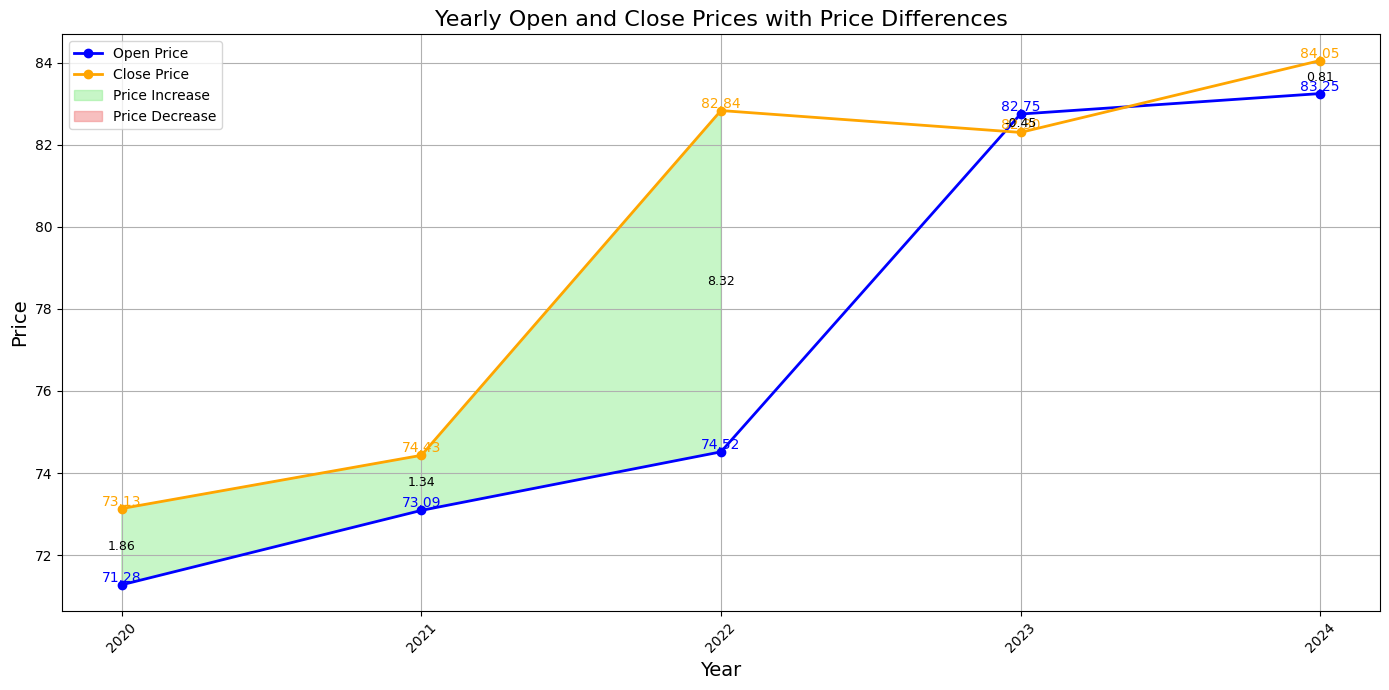

In [79]:
plt.figure(figsize=(14, 7))

yearly_data = data.groupby('year').agg({
    'High': 'max',
    'Low': 'min',
    'Open': 'first',
    'Close': 'last'
}).reset_index()

plt.plot(yearly_data['year'], yearly_data['Open'], marker='o', label='Open Price', color='blue', linewidth=2)
plt.plot(yearly_data['year'], yearly_data['Close'], marker='o', label='Close Price', color='orange', linewidth=2)

price_difference = yearly_data['Close'] - yearly_data['Open']
plt.fill_between(yearly_data['year'], yearly_data['Open'], yearly_data['Close'],
                 where=(price_difference > 0), color='lightgreen', alpha=0.5, label='Price Increase')
plt.fill_between(yearly_data['year'], yearly_data['Open'], yearly_data['Close'],
                 where=(price_difference <= 0), color='lightcoral', alpha=0.5, label='Price Decrease')

for index, row in yearly_data.iterrows():
    plt.text(row['year'], row['Open'], f"{row['Open']:.2f}", color='blue', ha='center', va='bottom')
    plt.text(row['year'], row['Close'], f"{row['Close']:.2f}", color='orange', ha='center', va='bottom')

for index, row in yearly_data.iterrows():
    plt.text(row['year'], (row['Open'] + row['Close']) / 2,
             f"{price_difference[index]:.2f}",
             color='black', ha='center', va='center', fontsize=9)

plt.title('Yearly Open and Close Prices with Price Differences', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.xticks(yearly_data['year'], rotation=45)
plt.grid(True) 
plt.legend()
plt.tight_layout()
plt.show()
     

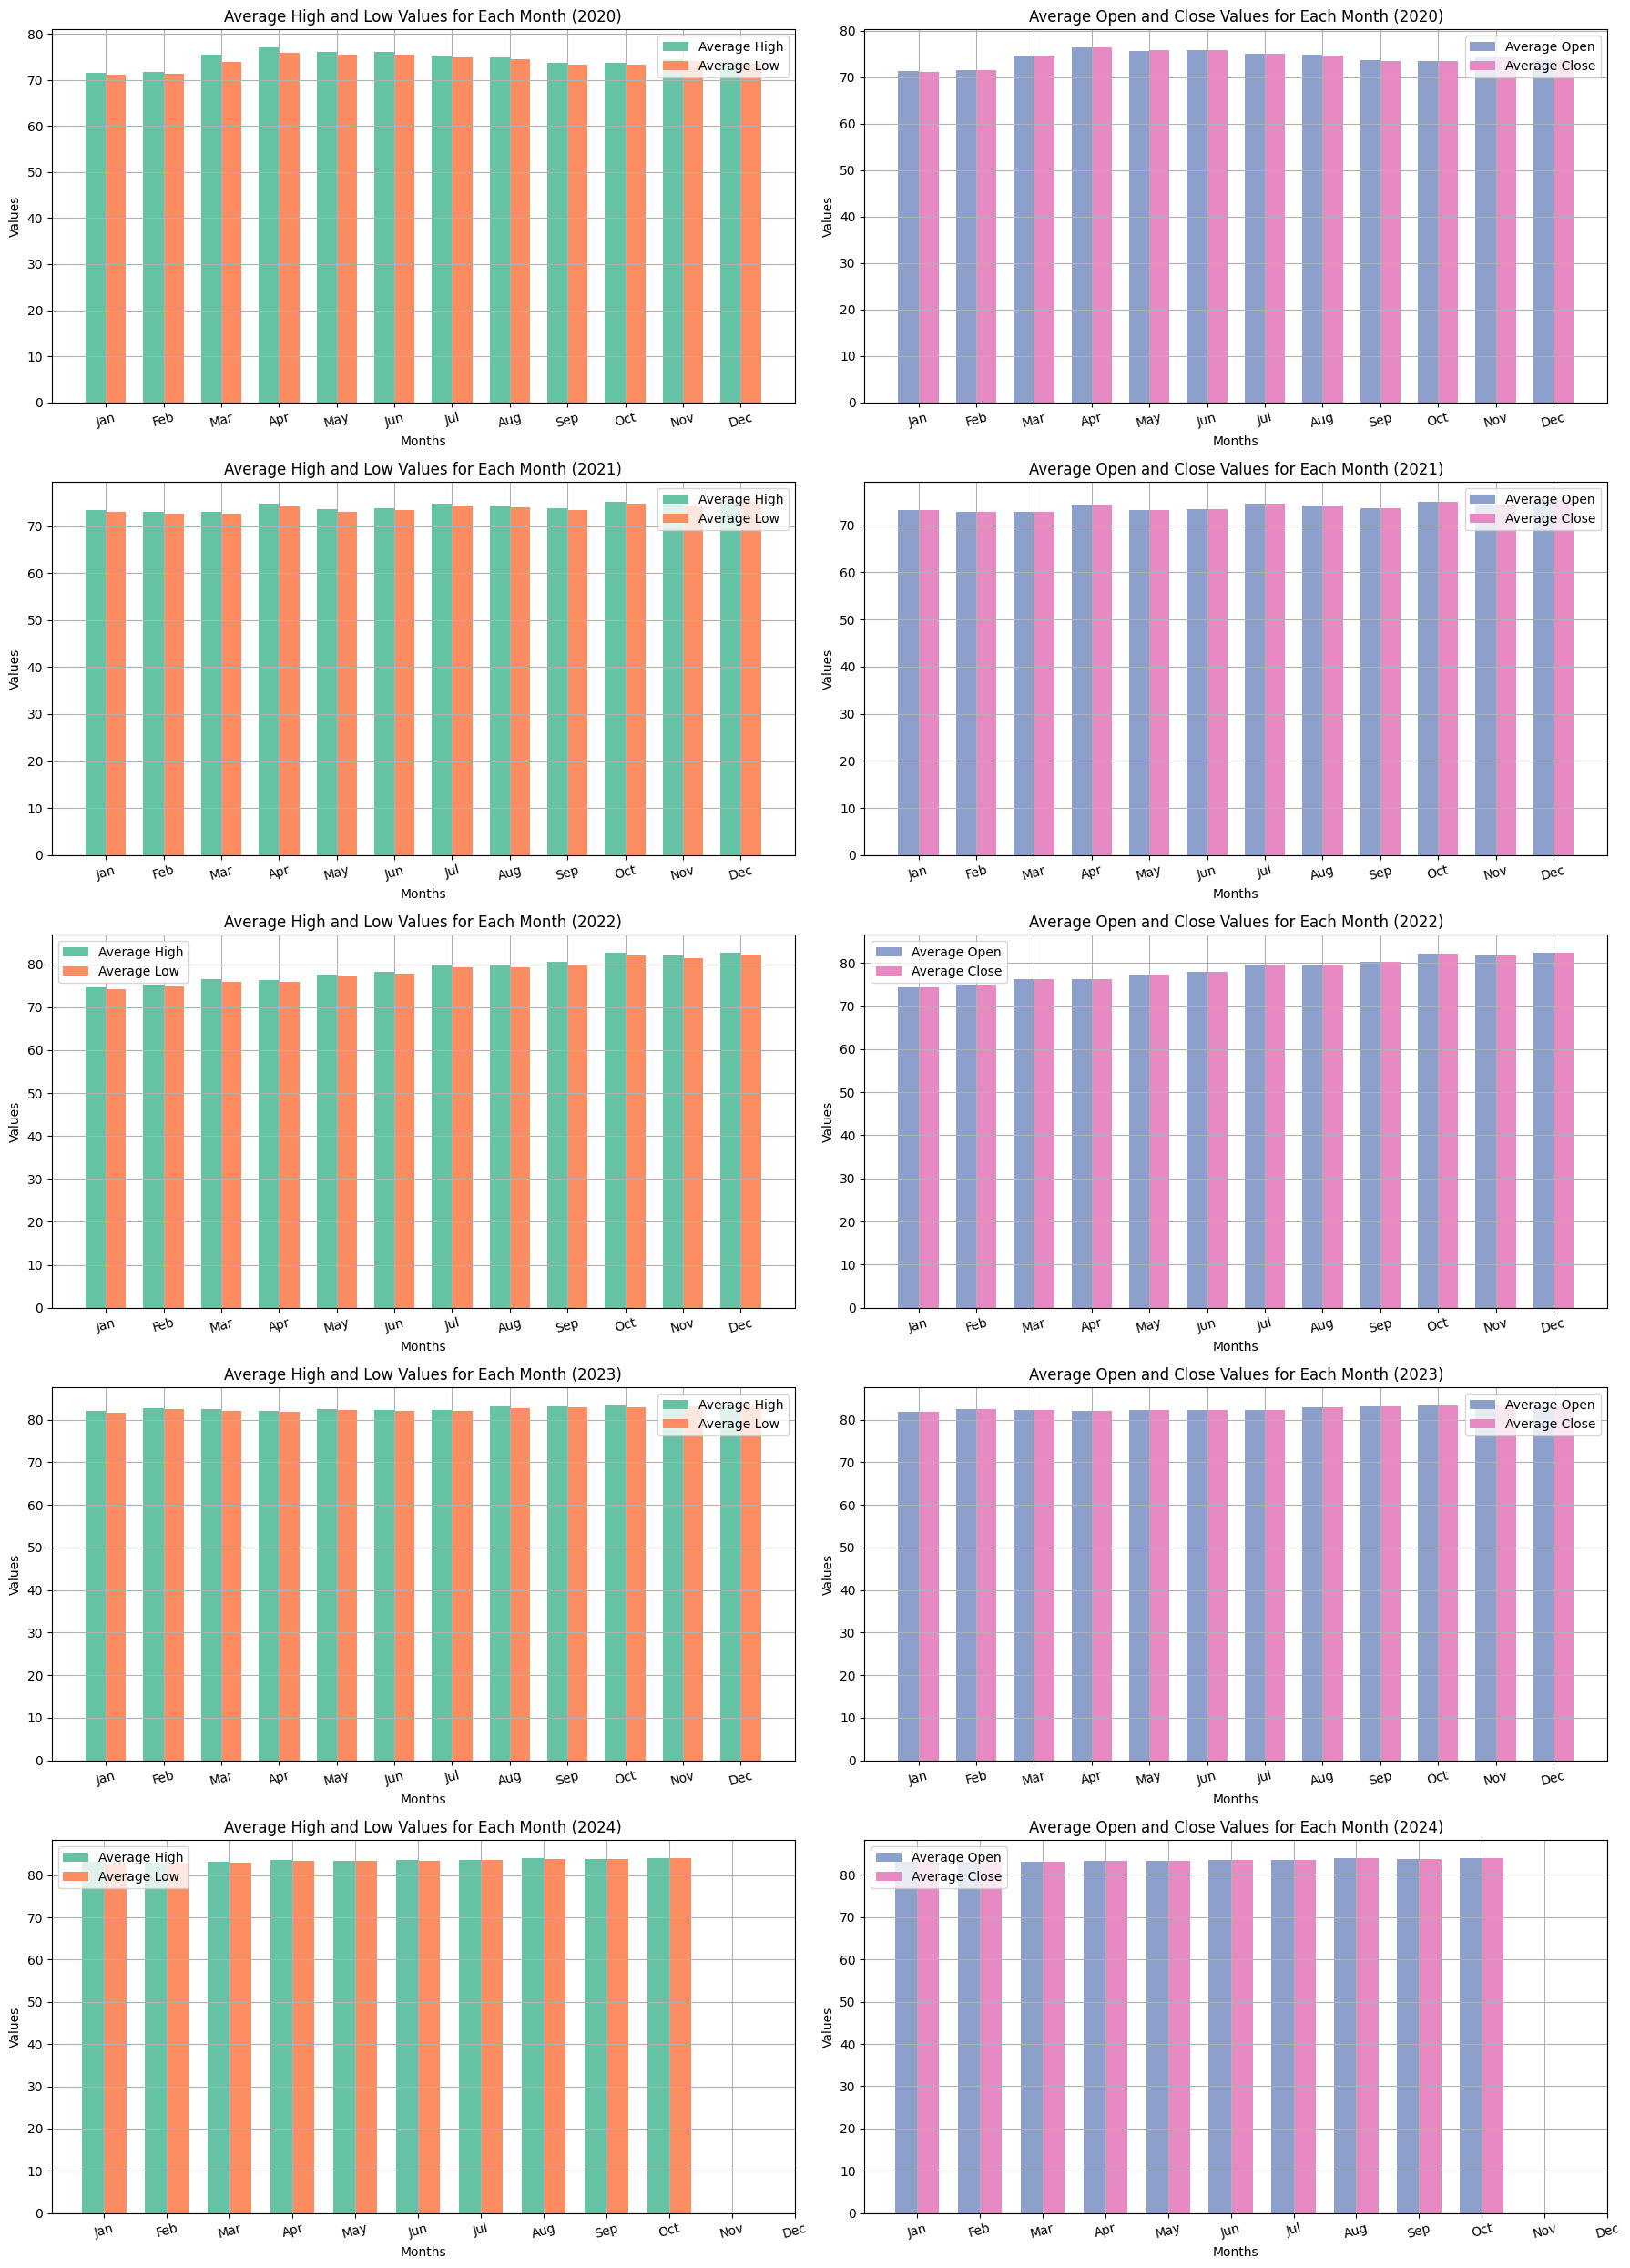

In [80]:
years = data['year'].unique()

fig, axs = plt.subplots(nrows=len(years), ncols=2, figsize=(18, 5 * len(years)))

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i, year in enumerate(years):
    df_year = data[data['year'] == year]

    full_month_index = pd.Index(range(1, 13))

    high_values = df_year.groupby('month')['High'].mean().reindex(full_month_index)
    low_values = df_year.groupby('month')['Low'].mean().reindex(full_month_index)

    open_values = df_year.groupby('month')['Open'].mean().reindex(full_month_index)
    close_values = df_year.groupby('month')['Close'].mean().reindex(full_month_index)

    bar_width = 0.35

    axs[i, 0].bar(high_values.index - bar_width / 2, high_values, bar_width, label='Average High', color='#66c2a5')
    axs[i, 0].bar(low_values.index + bar_width / 2, low_values, bar_width, label='Average Low', color='#fc8d62')

    axs[i, 0].set_xlabel('Months')
    axs[i, 0].set_ylabel('Values')
    axs[i, 0].set_title(f'Average High and Low Values for Each Month ({year})')
    axs[i, 0].set_xticks(full_month_index)
    axs[i, 0].set_xticklabels(month_names, rotation=15)
    axs[i, 0].legend()
    axs[i, 0].grid(True)

    axs[i, 1].bar(open_values.index - bar_width / 2, open_values, bar_width, label='Average Open', color='#8da0cb')
    axs[i, 1].bar(close_values.index + bar_width / 2, close_values, bar_width, label='Average Close', color='#e78ac3')

    axs[i, 1].set_xlabel('Months')
    axs[i, 1].set_ylabel('Values')
    axs[i, 1].set_title(f'Average Open and Close Values for Each Month ({year})')
    axs[i, 1].set_xticks(full_month_index)
    axs[i, 1].set_xticklabels(month_names, rotation=15)
    axs[i, 1].legend()
    axs[i, 1].grid(True)

plt.tight_layout()
plt.show()

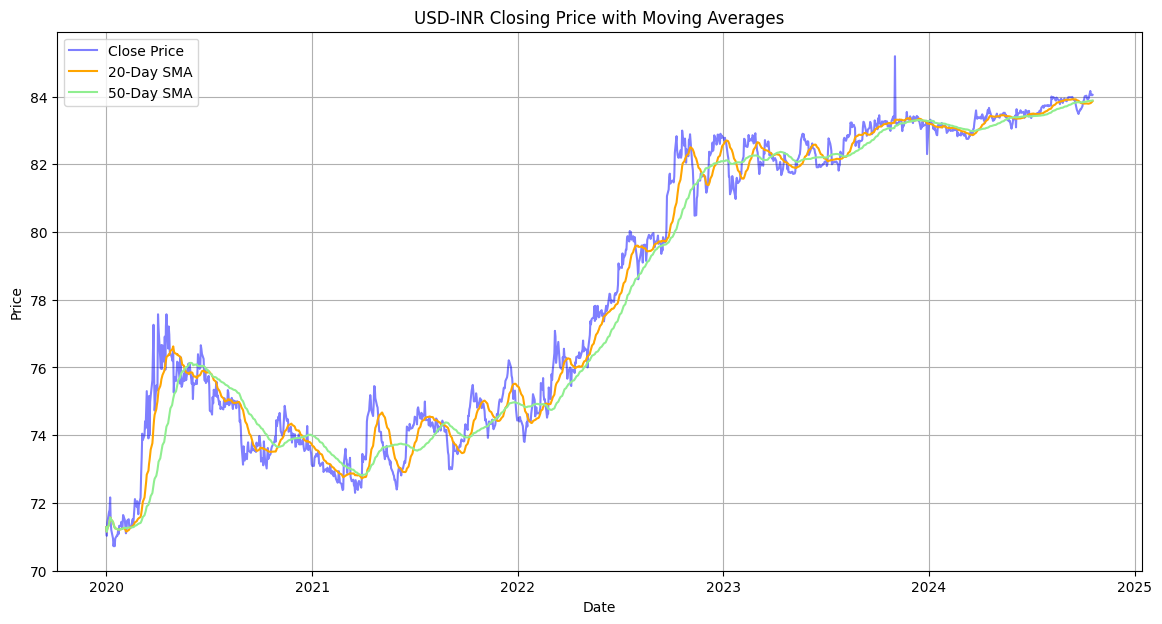

In [81]:
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Close'], label='Close Price', color='blue', alpha=0.5)
plt.plot(data['Date'], data['SMA_20'], label='20-Day SMA', color='orange')
plt.plot(data['Date'], data['SMA_50'], label='50-Day SMA', color='lightgreen')
plt.title('USD-INR Closing Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

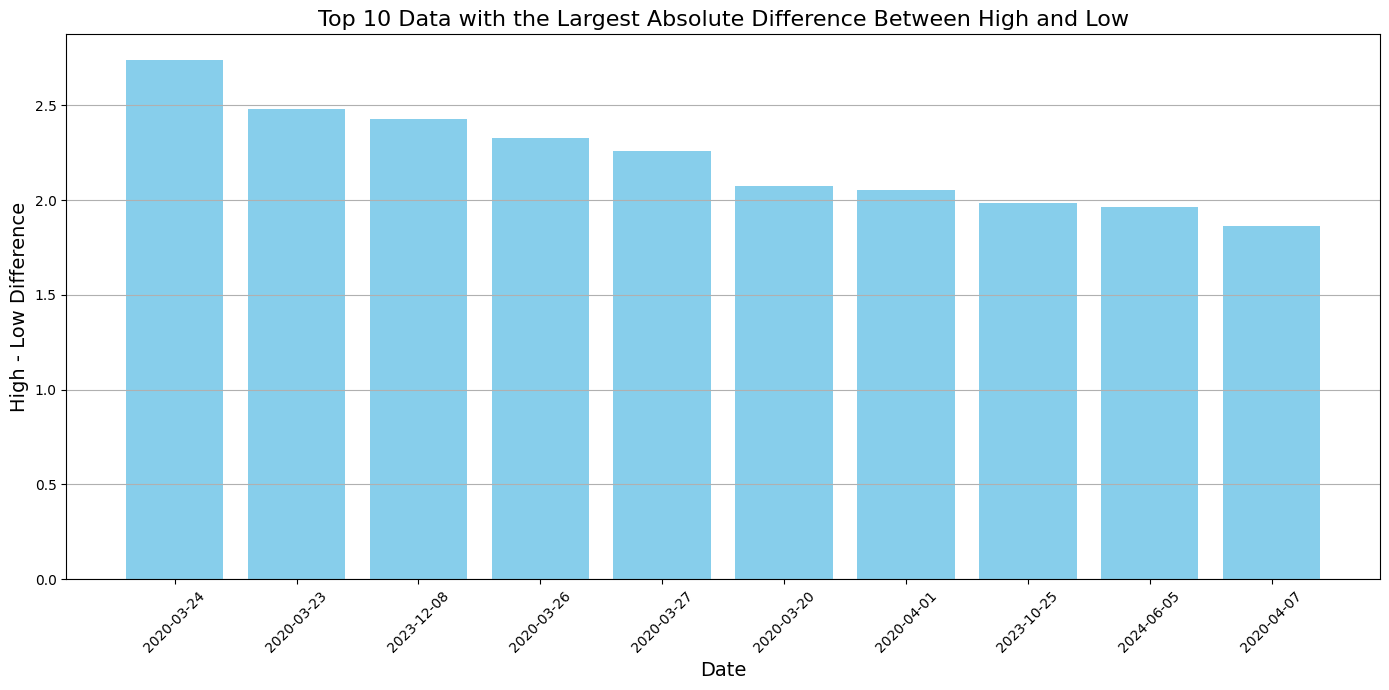

In [82]:
data['High_Low_Difference'] = data['High'] - data['Low']

top_10_high_low = data.nlargest(10, 'High_Low_Difference')[['Date', 'High_Low_Difference']]
top_10_high_low['Date'] = pd.to_datetime(top_10_high_low['Date'])

plt.figure(figsize=(14, 7))
plt.bar(top_10_high_low['Date'].dt.strftime('%Y-%m-%d'), top_10_high_low['High_Low_Difference'], color='skyblue')
plt.title('Top 10 Data with the Largest Absolute Difference Between High and Low', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('High - Low Difference', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
     

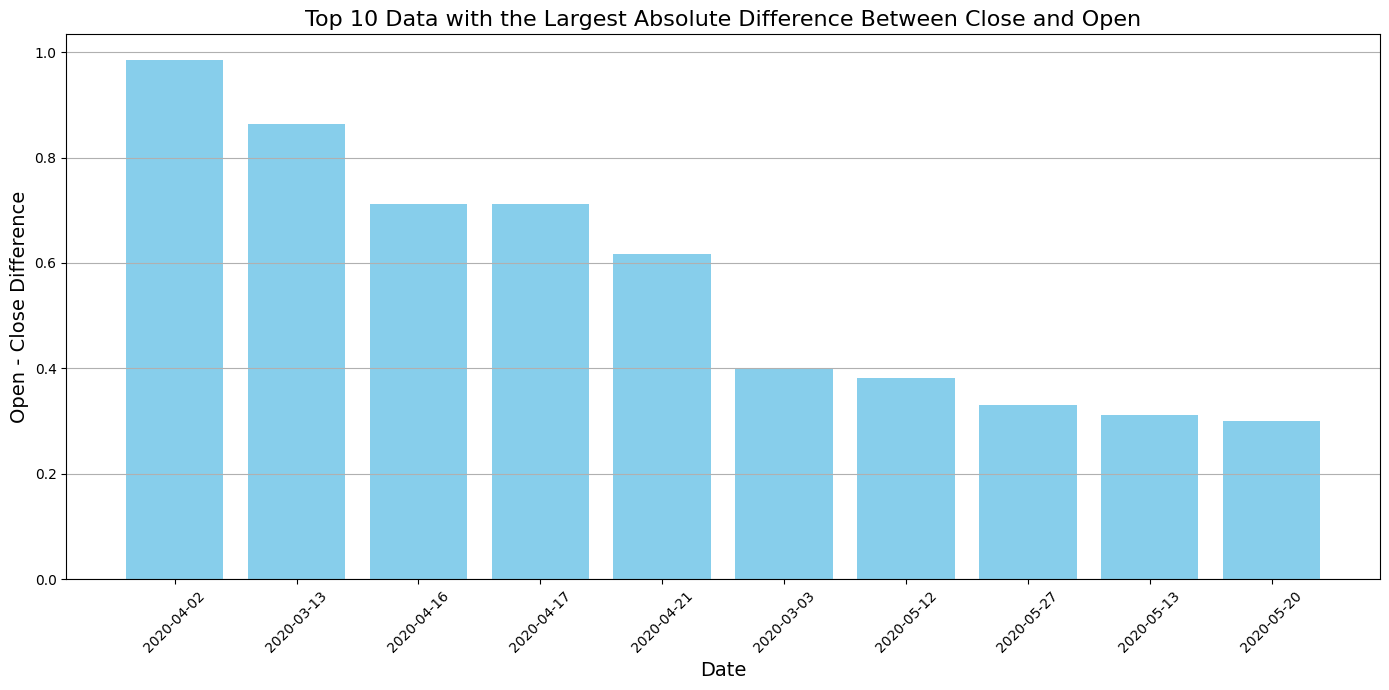

In [83]:
data['Open_Close_Difference'] = data['Close'] - data['Open']

top_10_open_close = data.nlargest(10, 'Open_Close_Difference')[['Date', 'Open_Close_Difference']]
top_10_open_close['Date'] = pd.to_datetime(top_10_open_close['Date'])

plt.figure(figsize=(14, 7))
x = range(len(top_10_open_close))

plt.bar(x, top_10_open_close['Open_Close_Difference'], color='skyblue')
plt.title('Top 10 Data with the Largest Absolute Difference Between Close and Open', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Open - Close Difference', fontsize=14)
plt.xticks(x, top_10_open_close['Date'].dt.strftime('%Y-%m-%d'), rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

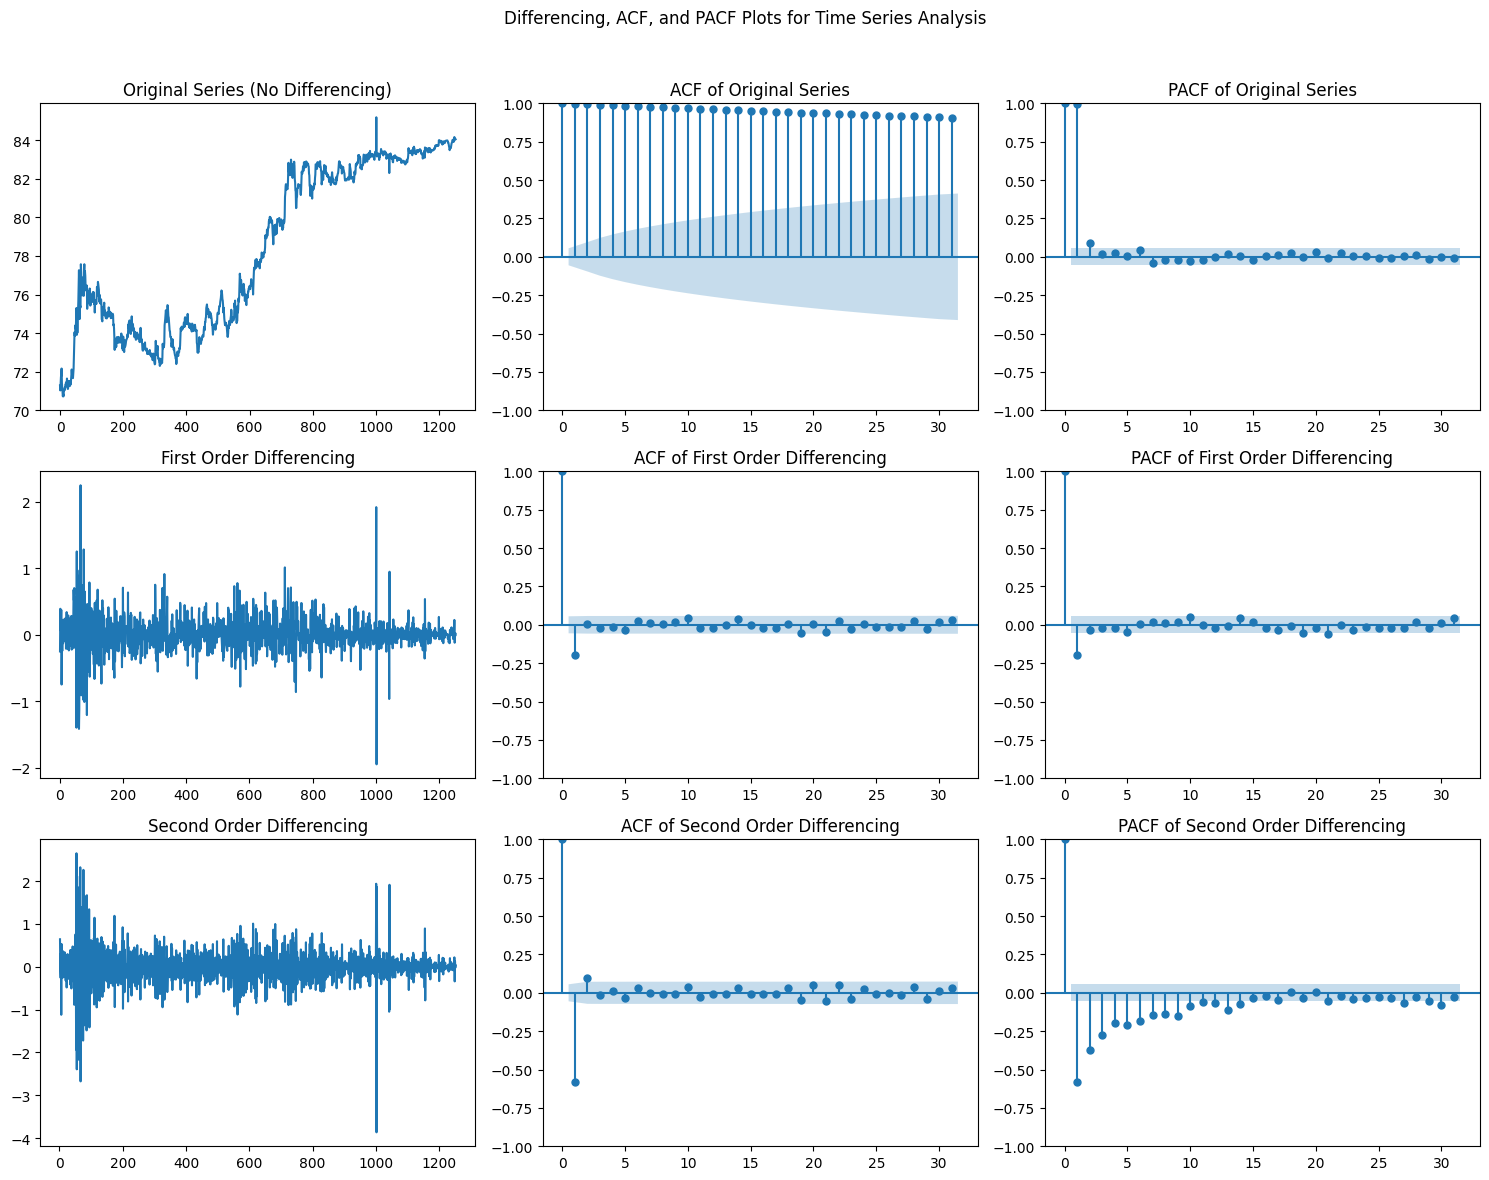

In [84]:
data = data['Close']

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Differencing, ACF, and PACF Plots for Time Series Analysis")

# No differencing
axes[0, 0].plot(data)
axes[0, 0].set_title("Original Series (No Differencing)")
plot_acf(data, ax=axes[0, 1])
axes[0, 1].set_title("ACF of Original Series")
plot_pacf(data, ax=axes[0, 2])
axes[0, 2].set_title("PACF of Original Series")

# First order differencing
data_diff1 = data.diff().dropna()
axes[1, 0].plot(data_diff1)
axes[1, 0].set_title("First Order Differencing")
plot_acf(data_diff1, ax=axes[1, 1])
axes[1, 1].set_title("ACF of First Order Differencing")
plot_pacf(data_diff1, ax=axes[1, 2])
axes[1, 2].set_title("PACF of First Order Differencing")

# Second order differencing
data_diff2 = data.diff().diff().dropna()
axes[2, 0].plot(data_diff2)
axes[2, 0].set_title("Second Order Differencing")
plot_acf(data_diff2, ax=axes[2, 1])
axes[2, 1].set_title("ACF of Second Order Differencing")
plot_pacf(data_diff2, ax=axes[2, 2])
axes[2, 2].set_title("PACF of Second Order Differencing")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
     

In [85]:
type(data)

pandas.core.series.Series

In [89]:
if isinstance(data.index, pd.DatetimeIndex):
    print("The 'Date' column is successfully set as the index and it is a DatetimeIndex.")
else:
    data.set_index('Date', inplace=True)
    print("The 'Date' column was not set as the index. It has now been set as the index.")

AttributeError: 'Series' object has no attribute 'set_index'

In [87]:
# Assuming df['Close'] is the time series data
# Calculate weekly, monthly, and yearly averages
df_weekly = data['Close'].resample('W').mean()
df_monthly = data['Close'].resample('M').mean()
df_yearly = data['Close'].resample('Y').mean()

# Create the subplot layout
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# First Row: Combined plot
axes[0, 1].plot(df_weekly.index, df_weekly.values, label='Weekly Avg', color='blue', linestyle='-')
axes[0, 1].plot(df_monthly.index, df_monthly.values, label='Monthly Avg', color='orange', linestyle='--')
axes[0, 1].plot(df_yearly.index, df_yearly.values, label='Yearly Avg', color='green', linestyle='-.')
axes[0, 1].set_title("Combined Weekly, Monthly, and Yearly Average Exchange Rates")
axes[0, 1].legend()
axes[0, 1].grid()

# Second Row: Individual subplots
# Weekly Average
axes[1, 0].plot(df_weekly.index, df_weekly.values, color='blue')
axes[1, 0].set_title("Weekly Average Exchange Rate")
axes[1, 0].grid()

# Monthly Average
axes[1, 1].plot(df_monthly.index, df_monthly.values, color='orange')
axes[1, 1].set_title("Monthly Average Exchange Rate")
axes[1, 1].grid()

# Yearly Average
axes[1, 2].plot(df_yearly.index, df_yearly.values, color='green')
axes[1, 2].set_title("Yearly Average Exchange Rate")
axes[1, 2].grid()

# Format the x-axis to show only years
axes[1, 2].xaxis.set_major_locator(mdates.YearLocator())
axes[1, 2].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

[fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data()]
plt.tight_layout()
plt.show()

KeyError: 'Close'